Bankruptcy Prediction Analysis

In [142]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

In [107]:
#url = "https://raw.githubusercontent.com/adam-datasci/RiskAnalytics/main/Data/american_bankruptcy.csv?"
url = "Data/american_bankruptcy_normalized.csv"
df = pd.read_csv(url)

In [149]:
features = [
    'wc_to_ta_pct',
    're_to_ta_pct',
    'ebit_to_ta_pct',
    'mv_to_tl_pct',
    'tr_to_ta_pct',
    'tltd_to_te_pct',
    'np_to_tr_pct',
    'ebitda_to_tr_pct',
    'gp_to_tr_pct',
    'ca_to_cl_pct',
    'np_to_ta_pct',
    'default'
    ]


features = [
    'wc_to_ta',
    're_to_ta',
    'ebit_to_ta',
    'mv_to_tl',
    'tr_to_ta',
    'default'
    ]

industries = ['Agriculture','Mining','Construction','Manufacturing','Transportation','Wholesale','Retail','Finance','Services','Public']
industries = ['Manufacturing']

df_filtered = df[df['Division'].isin(industries)]
df_filtered = df_filtered[features]

In [150]:
#Create a sample of a specific size for the filtered data
sample_size = 1000
df_filtered_sample = df_filtered.sample(sample_size, random_state=1)

#pull out both the default and non-default periods
default_periods = df_filtered[df['default'] == 1]
non_default_periods = df_filtered[df['default'] == 0]
no_rows = default_periods.shape[0]

#Create a balanced dataset
df_sample_non_default = non_default_periods.sample(no_rows, random_state=1)
df_balanced = pd.concat([default_periods, df_sample_non_default])

X = df_balanced.drop('default', axis=1)
y = df_balanced['default']

C:\Users\adamk\AppData\Local\Temp\ipykernel_14168\1723107776.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default_periods = df_filtered[df['default'] == 1]
C:\Users\adamk\AppData\Local\Temp\ipykernel_14168\1723107776.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_default_periods = df_filtered[df['default'] == 0]


In [ ]:
def clip_to_percentiles(column, min_percentile, max_percentile):
    lower = column.quantile(min_percentile)
    upper = column.quantile(max_percentile)
    return column.clip(lower, upper)

X = X.apply(clip_to_percentiles, args=(0.05,0.95), axis=0)

In [151]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

df_filtered = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)

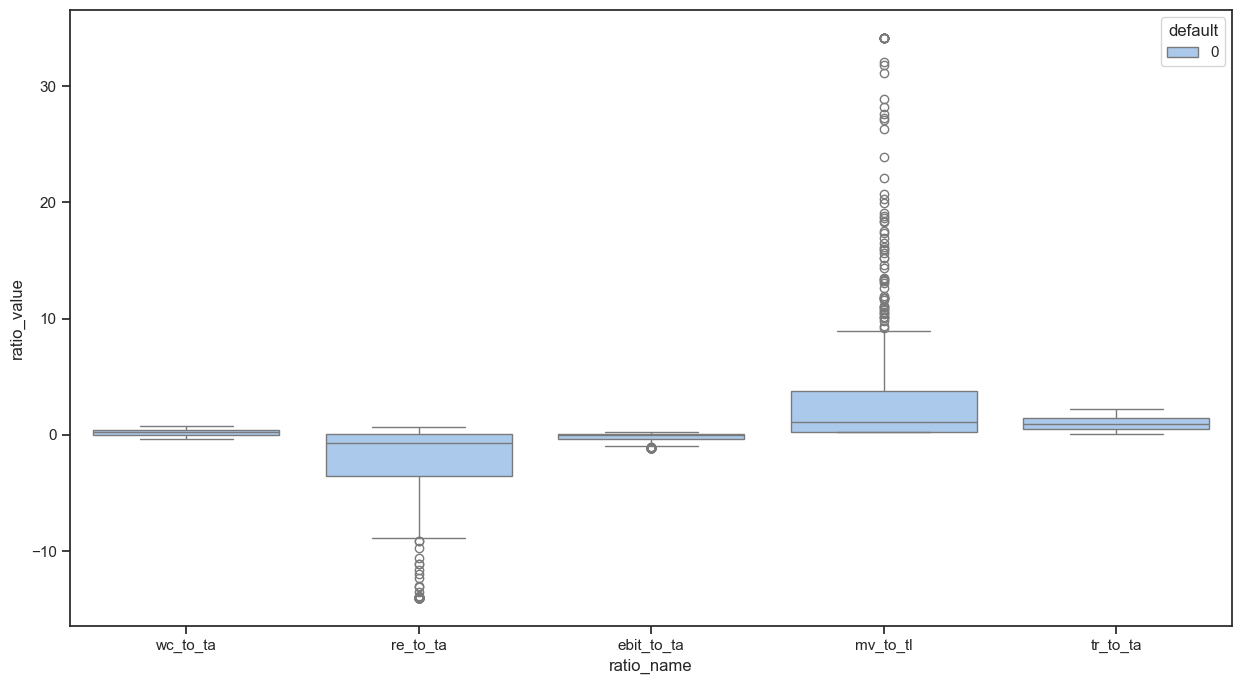

In [144]:
df_filtered_sample_by_status = df_balanced.melt(id_vars='default', value_vars=features[:-1],var_name='ratio_name',value_name='ratio_value')

plt.figure(figsize=(15, 8))
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x='ratio_name', y='ratio_value', hue='default', data=df_filtered_sample_by_status)
plt.show()

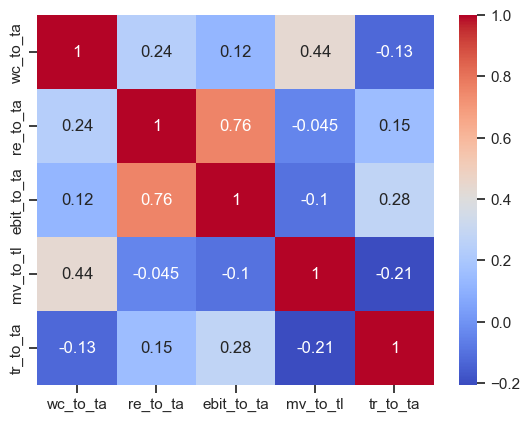

In [138]:
correlation_matrix = X.corr()

# Heatmap of the correlation matrix
dataplot = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [140]:
model = sm.Logit(y_train, X_train)
result = model.fit()
#model = XGBClassifier(learning_rate =0.1, randon_state=42)
#result = model.fit(X_train,y_train)

         Current function value: 0.000000
         Iterations: 35


c:\Users\adamk\anaconda3\envs\main\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\adamk\anaconda3\envs\main\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [114]:
predictions = result.predict_proba(X_test)
predicted_classes = (predictions > 0.5).astype(int)

In [119]:
accuracy = accuracy_score(y_test, predicted_classes[:,1])
conf_matrix = confusion_matrix(y_test, predicted_classes[:,1])

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8095238095238095
Confusion Matrix:
 [[76 17]
 [19 77]]


In [141]:
result.summary()

c:\Users\adamk\anaconda3\envs\main\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\adamk\anaconda3\envs\main\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\adamk\anaconda3\envs\main\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\adamk\anaconda3\envs\main\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSep

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  351
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Apr 2024   Pseudo R-squ.:                     inf
Time:                        14:27:21   Log-Likelihood:            -4.6513e-06
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wc_to_ta      41.8421   2.46e+04      0.002      0.999   -4.81e+04    4.82e+04
re_to_ta      27.7510   7.92e+04      0.000      1.000   -1.55e+05    1.55e+05
ebit_to_ta    60.8580   4.77e+05      0.000      1.000   -9.35e+05    9.36e+05
mv_to_tl       0.5184    240.941      0.002      0.998    -471.717     472.754
tr_to_ta    -130.4215   1.04e+05     -0.001      0.999   -2.05e+05    2.04e+05
==============================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

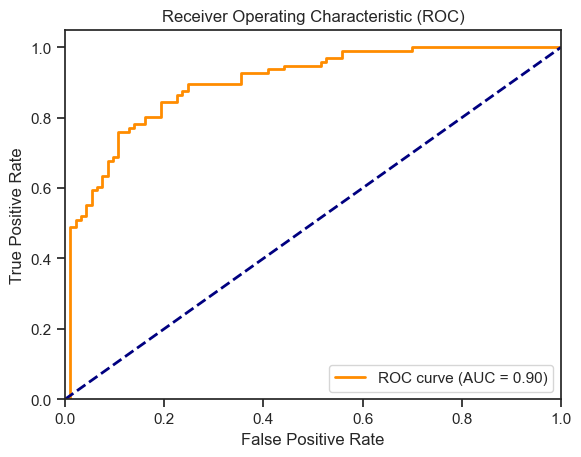

In [121]:
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

array([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1])